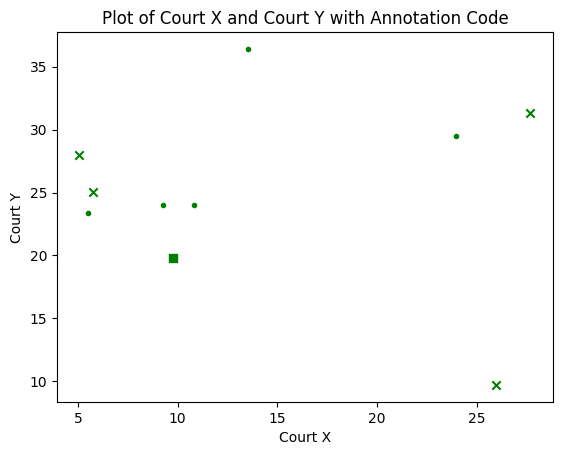

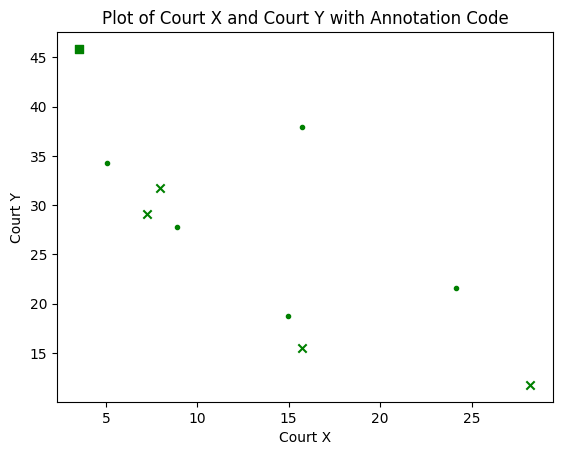

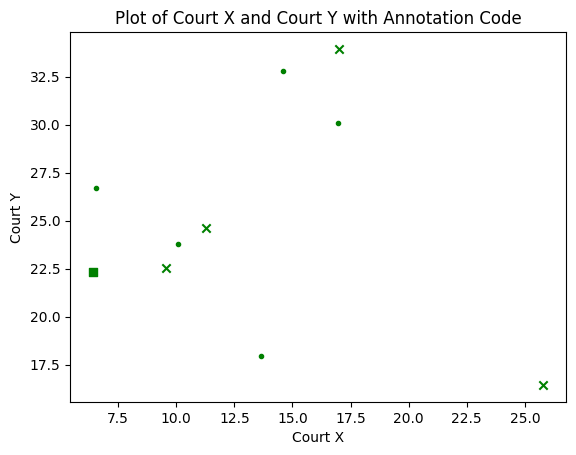

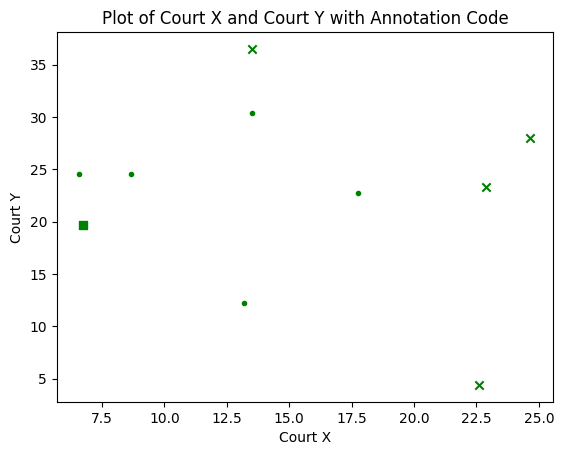

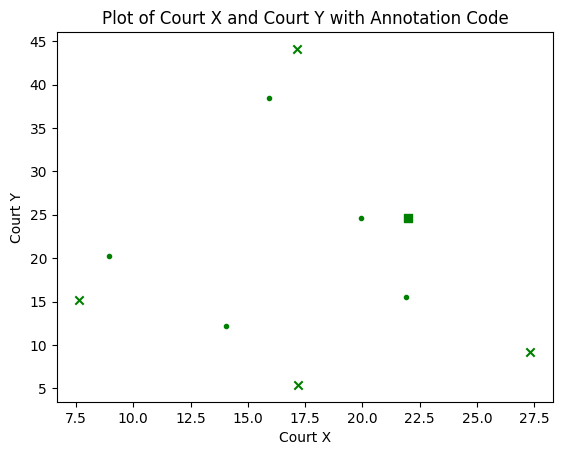

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

from helpers import plot_basketball_court
locations = pd.read_csv('raw-data/train_locs.csv')
play_by_play = pd.read_csv('raw-data/train_pbp.csv')

#Feels like its cheating the problem at hand to predict based on teams or conferences
play_by_play = play_by_play.drop(['team', 'opponent', 'conference', 'opp_conference'], axis=1)

#Pivot data to one neat table
merged_df = pd.merge(play_by_play, locations, on='id', how='inner')

#Convert coordinates to only reference one direction of the court
#For now lets assume that if the shooter is on the right side of the court, the right basket is the target
#Ignore half court shots+ for now
#If the shooter has x greater than 47, mirror all points
shooter_locations = locations[(locations['annotation_code'] == 's')]
merged_df_2 = pd.merge(merged_df, shooter_locations, on='id', how='inner', suffixes=('', '_shooter'))
#if merged_df_2['court_x_shooter'] > 47, then mirror court_x to be 94 - court_x
merged_df_2['court_x'] = merged_df_2.apply(lambda x: 94 - x['court_x'] if x['court_x_shooter'] > 47 else x['court_x'], axis=1)
cleaned_data = merged_df_2.drop(['court_x_shooter', 'court_y_shooter', 'annotation_code_shooter'], axis=1)

#draw some random visualizations
for i in range(0,5):
    new_cleaned_data = cleaned_data[i*10:(i*10)+10]
    # Extract the necessary columns
    annotation_code = new_cleaned_data['annotation_code']
    # Create the plot
    for n in annotation_code:
      court_x = new_cleaned_data['court_x'][(new_cleaned_data['annotation_code'] == n)]
      court_y = new_cleaned_data['court_y'][(new_cleaned_data['annotation_code'] == n)]
      if 't' in n:
         n = 'x'
      if 'd' in n:
         n = '.'
      color = 'green'
      plt.scatter(court_x, court_y, marker=n, color=color)

    # Add labels and title
    plt.xlabel('Court X')
    plt.ylabel('Court Y')
    plt.title('Plot of Court X and Court Y with Annotation Code')

    # Show the plot
    plt.show()



#extract some easy features

#run a regression